In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas
import math
from hmmlearn import hmm
from sklearn import mixture
from sklearn.mixture import BayesianGaussianMixture
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from create_train_test_val_maps import *

In [3]:
pc_vec = pandas.read_pickle('pc_vec.pkl')
pc_vec2 = np.array(pc_vec['prob']).reshape((7,1))

cost_prob = np.genfromtxt('cost_prob.csv',delimiter=',')
cost_prob = cost_prob.T

selected_codes = [0,45021, 44004, 43004, 45008, 45002, 45007] # first code is the ok
selected_codes = list(np.sort(selected_codes))
num_codes = len(selected_codes)

In [4]:
selected_repairs = pandas.read_pickle('cleaned_selected_repairs.pkl')
veh_repair_cost_map = {}

for idx, row in selected_repairs.iterrows():
    veh_id = row['Chassis\nReference\nNumber']
    if veh_id not in veh_repair_cost_map:
        veh_repair_cost_map[veh_id] = {}
    cost_str = row['Repair Cost']
    cost = 0
    if cost_str == 'very low':
        cost = 1
    elif cost_str == 'low':
        cost = 2
    elif cost_str == 'medium':
        cost = 3
    elif cost_str == 'high ':
        cost = 4
    elif cost_str == 'very high':
        cost = 5
    if cost==0:
        print("error: {}".format(veh_id))
    veh_repair_cost_map[veh_id][row['ATA6']] = cost

In [5]:
selected_repairs = pandas.read_pickle('cleaned_selected_repairs.pkl')
veh_repair_map = {}
for veh_id, repairs in selected_repairs.groupby(['Chassis\nReference\nNumber']):
    veh_repair_map[veh_id] = repairs['ATA6'].values

In [6]:
# Source: Julio's helper functions for HMM in AA228 project
# get global index from (row, col) index
def sub2ind(array_shape, row, col):
    ind = row*array_shape[1] + col
    if row < 0 or row >= array_shape[0]:
        ind = -1
    if col < 0 or col >= array_shape[1]:
        ind = -1
    return ind

# get (row, col) index from global index
def ind2sub(array_shape, ind):
    row = int(ind) / array_shape[1]
    col = ind % array_shape[1]
    if ind < 0:
        row = -1
        col = -1
    if ind >=  array_shape[0]*array_shape[1]:
        row = -1
        col = -1
    return (row, col)

def softmax(x):
    """
    Compute softmax function for input. 
    Use tricks from previous assignment to avoid overflow
    """
    ### YOUR CODE HERE
    xshift = np.max(x, axis = 1)
    xshift = xshift.reshape((x.shape[0],1))
    x = x - xshift
    s = np.exp(x) / np.sum(np.exp(x),axis = 1).reshape((x.shape[0],1))
    ### END YOUR CODE
    return s

In [11]:
# Julio's code written for training HMM in AA228 project
# Made a slight amendment to fit gmm instead of hmm
def start_train_gmm(selected_codes, train_map_revived, num_iter, num_states, num_inits):    
    models = {}
    codes = []
    code_window_map = {}
    cat_col = [0, 4, 8, 10, 11, 12, 16, 47]
    for vehicleID in train_map_revived.keys():
        for ATA6code in train_map_revived[vehicleID].keys():
            if ATA6code not in selected_codes:
                continue
            if ATA6code not in code_window_map:
                code_window_map[ATA6code] = {}
            for time_window in train_map_revived[vehicleID][ATA6code].keys():
                if time_window not in code_window_map[ATA6code]:
                    code_window_map[ATA6code][time_window] = []
                for sequence_of_snapshots in train_map_revived[vehicleID][ATA6code][time_window]:
                    code_window_map[ATA6code][time_window].append(sequence_of_snapshots)

    for ATA6code in code_window_map.keys():
        for time_window in code_window_map[ATA6code].keys():
            lengths = []
            listofsequences = code_window_map[ATA6code][time_window]
            X = pandas.concat(listofsequences).as_matrix()
            Xnum = np.delete(X,cat_col,axis=1)
            for sequence in listofsequences:
                lengths.append(sequence.shape[0]) 
            #models[(ATA6code, time_window)] = hmm.GaussianHMM(n_components=num_states, n_iter=num_iter).fit(X.astype(float),lengths)
            gmm = mixture.GaussianMixture(n_components=num_states, covariance_type='full', max_iter=num_iter, n_init=num_inits)
            #dpgmm = mixture.BayesianGaussianMixture(n_components=num_states, covariance_type='full')
            models[(ATA6code, time_window)] = gmm.fit(X.astype(float))
            #models[(ATA6code, time_window)] = gmm.fit(Xnum.astype(float))
            #models[(ATA6code, time_window)] = dpgmm.fit(X.astype(float))
    return models

In [37]:
# Julio's code written for evaluating HMM in AA228's project
# Made a slight amendment to calculate & output #true positives, #actual positives, #predicted positives
def get_results(alpha,selected_codes,val_map_revived,veh_repair_map,num_time_windows, code_probs, cost_prob, vehicle_repair_cost_map):    
    # VALIDATION ACCURACY
    num_codes = len(selected_codes)
    
    # Arrays to store true positive, actual positive, predicted positive
    trueP_code = {}
    actualP_code = {}
    predP_code = {}
    trueP_win = {}
    actualP_win = {}
    predP_win = {}
    for i in selected_codes:
        trueP_code[i]=0
        actualP_code[i]=0
        predP_code[i]=0
    for i in range(num_time_windows):
        trueP_win[i]=0
        actualP_win[i]=0
        predP_win[i]=0        
    
    lengths = []
    for vehicleID in val_map_revived.keys():
        for ATA6code in val_map_revived[vehicleID].keys():
            if ATA6code not in selected_codes:
                continue
            for time_window in val_map_revived[vehicleID][ATA6code].keys():
                # append #sequences for (vehicleID,ATA6code,time_window)
                lengths.append(len(val_map_revived[vehicleID][ATA6code][time_window]))
    # total number of sequences
    num_val = sum(lengths)
    #print(lengths)

    sample = 0
    labels = []
    
    
    # mse scores
    code_scores_mse = np.ones(num_val)
    window_scores_mse = np.ones(num_val)
    cost_scores_mse = np.ones(num_val)
    
    # accuracy scores
    code_scores_acc = np.zeros(num_val)
    window_scores_acc = np.zeros(num_val)
    cost_scores_acc = np.zeros(num_val)
    
    log_likelihoods = np.zeros((num_val, num_codes, num_time_windows))
    probabilities = np.zeros((num_val, num_codes, num_time_windows))
    for vehicleID in val_map_revived.keys():
        for ATA6code in val_map_revived[vehicleID].keys():
            if ATA6code not in selected_codes:
                continue
            for time_window in val_map_revived[vehicleID][ATA6code].keys():
                for sequence_of_snapshots in val_map_revived[vehicleID][ATA6code][time_window]:
                    labels.append([selected_codes.index(ATA6code),time_window])
                    x = sequence_of_snapshots.as_matrix() 
                    for pair in models.keys():
                        c = selected_codes.index(pair[0])
                        w = pair[1]
                        if c == 0 & w == 0:
            
                            #continue
                            #print(x.shape)
                            temp_score = models[pair].score(x.astype(float))
                            for i in range(len(log_likelihoods[sample,c,:])):
                                log_likelihoods[sample,c,i] = temp_score
                        else:
                            #print(x.shape)
                            log_likelihoods[sample,c,w] = models[pair].score(x.astype(float))
                    
                    # Compute Softmax Prob Matrix
                    probabilities_temp = softmax(log_likelihoods[sample].reshape(1,num_codes*num_time_windows))
                    probabilities[sample] = probabilities_temp.reshape(num_codes, num_time_windows) 
                    posterior_code_probs = np.sum(probabilities[sample]*code_probs,axis=1).reshape(1,7)
                    #print(posterior_code_probs.shape)
                    #print(cost_prob.shape)
                    predicted_cost = np.argmax(np.dot(posterior_code_probs,cost_prob))
                    # Get marginal max 
                    #argmax_window = np.argmax(np.dot(probabilities[sample].T,code_probs))
                    #argmax_code = np.argmax(np.sum(probabilities[sample]*code_probs,axis=1))
                    argmax_window = np.argmax(np.sum(probabilities[sample],axis=0))
                    argmax_code = np.argmax(np.sum(probabilities[sample],axis=1))
                    #max_index = np.unravel_index(probabilities[sample].argmax(), probabilities[sample].shape)

                    # MSE
                    #----------
                    # code
                    actualP_code[ATA6code] += 1  # update actual code freq
                    predP_code[selected_codes[argmax_code]] += 1  # update predicted code freq
                    if  argmax_code == selected_codes.index(ATA6code):
                        code_scores_mse[sample] = 0
                        trueP_code[ATA6code]+=1  # update true positive freq                        
                    elif vehicleID in veh_repair_map and selected_codes[argmax_code] in veh_repair_map[vehicleID]:
                        code_scores_mse[sample] = 1-alpha
                        
                    
                    # window
                    actualP_win[time_window] += 1  # update actual window freq
                    predP_win[argmax_window] += 1  # update predicted window freq
                    if argmax_window == time_window:
                        trueP_win[time_window] += 1
                    #window_scores_mse[sample] = math.pow(argmax_window - time_window,2)
                    window_scores_mse[sample] = argmax_window - time_window
                    
                    
                    # cost
                    if vehicleID in vehicle_repair_cost_map and ATA6code in vehicle_repair_cost_map[vehicleID]:
                        cost_scores_mse[sample] = math.pow(predicted_cost - vehicle_repair_cost_map[vehicleID][ATA6code],2)
                    else:
                        cost_scores_mse[sample] = math.pow(predicted_cost - 0,2)
                    
                    # Accuracy
                    #----------
                    # code
                    #print('argmax_code: ', argmax_code)
                    #print('vehicleID: ', vehicleID)
                    if  argmax_code == selected_codes.index(ATA6code):
                        code_scores_acc[sample] = 1
                    elif vehicleID in veh_repair_map and selected_codes[argmax_code] in veh_repair_map[vehicleID]:
                        code_scores_acc[sample] = alpha
                    # window
                    window_scores_acc[sample] = 1.0/(1.0 + math.pow(argmax_window - time_window,2))
                    # cost
                    if vehicleID in vehicle_repair_cost_map and ATA6code in vehicle_repair_cost_map[vehicleID]:
                        cost_scores_acc[sample] = (predicted_cost == vehicle_repair_cost_map[vehicleID][ATA6code])
                    else:
                        cost_scores_acc[sample] = (predicted_cost == 0.0)
                    sample = sample+1        
    
    #print(code_scores_acc)
    labels = np.asarray(labels)
    code_error = np.mean(code_scores_mse)
    window_error = window_scores_mse #np.mean(window_scores_mse) 
    cost_error = np.mean(cost_scores_mse)
    code_accuracy = np.mean(code_scores_acc)
    window_accuracy = np.mean(window_scores_acc)
    cost_accuracy = np.mean(cost_scores_acc)
    
    return code_error, window_error, cost_error, code_accuracy, window_accuracy, cost_accuracy, trueP_code, trueP_win, actualP_code, actualP_win, predP_code, predP_win

In [14]:
def confusion_metrics(categories, trueP, actualP, predP):
#===================
# Inputs: 
# categories: classification categories
# trueP: dictionary: key = category, value = #true positive counts for that category
# actualP: dictionary: key = category, value = #actual positive counts for that category
# predP: dictionary: key = category, value = #predicted positive counts for that category
# Outputs:
# precision = #true positives/#predicted positives for each category (=nan if denominator is zero)
# recall = #true positives/#actual positives for each category
# f1 score = 2*(recall*precision)/(recall + precision) for each category
#===================
    accuracy = sum(trueP.values())/sum(actualP.values())
    precision = {}
    recall = {}
    f1 = {}
    
    for i in categories:        
        if predP[i] > 0:
            precision[i] = float(trueP[i])/predP[i]
        else:
            precision[i] = np.nan
        
        if actualP[i] > 0:
            recall[i] = float(trueP[i])/actualP[i]
        else:
            recall[i] = np.nan
        
        if (trueP[i] > 0):
            f1[i] = 2*(recall[i]*precision[i])/(recall[i] + precision[i])
        else:
            f1[i] = np.nan
    
    return accuracy, precision, recall, f1

In [42]:
def get_plots(Y, x, z_labels, title, xlabel, ylabel):
    for i in range(len(z_labels)):
        plot_label = z_labels[i]
        plt.plot(x,Y[i,:],label=plot_label)

    ax = plt.gca() # grab the current axis
    ax.set_xticks(x) # choose which x locations to have ticks
    ax.set_xticklabels(x) # set the labels to display at those ticks
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.suptitle("")
    plt.title(title)
    mylegend = plt.legend(loc="upper right",bbox_to_anchor=(1,1), title="(#Windows,WindowSize)")
    #mylegend = plt.legend(loc="right corner",bbox_to_anchor=(1,1), title="(#Inits)")
    plt.rcParams["figure.figsize"] = [6,5]
    plt.savefig(title.replace(" ", "_"), bbox_extra_artists=(mylegend,), bbox_inches="tight")
    plt.show()

In [40]:
code_errors ={}
window_errors = {}
cost_errors = {}
code_accuracies = {}
window_accuracies = {}
cost_accuracies = {}
code_precisions = {}
win_precisions = {}
code_recalls = {}
win_recalls = {}
code_f1_scores = {}
win_f1_scores = {}

num_states = 2
num_iter = 100
alpha = 0.5

hyper_tuples = [(1,500), (5,20), (5,50), (2,250), (5,100), (5,250), (10, 10), (10, 100)]
#num_win = [1,10,5,5,1,2,5,10,20]
#win_size = [50,10,20,50,500,250,100,50,25]
#num_win = [1,5,5,2,5,5,10,10]
#win_size = [500,20,50,250,100,250,10,100]
num_win = [1,2,5,10]
win_size = [500,250,100,50]

for i in range(len(num_win)):
#for num_windows in [10]:
    for num_states in range(2,11):
        num_windows = num_win[i]
        window_size = win_size[i]
        num_inits = 1
        print('\ngetting maps for: num_windows = %d, window_size = %d, num_states = %d, num_inits = %d' % (num_windows,window_size,num_states,num_inits))
        train_combined, val_combined, test_combined = load_maps(num_windows, window_size)
        print('training...')
        models = start_train_gmm(selected_codes, train_combined, num_iter, num_states, num_inits)
        print('validating and getting results...')
        code_error, window_error, cost_error, code_accuracy, window_accuracy, cost_accuracy, trueP_code, trueP_win, actualP_code, actualP_win, predP_code, predP_win = get_results(alpha,selected_codes,val_combined,veh_repair_map,num_windows, pc_vec2, cost_prob, veh_repair_cost_map)
        #print('ATA6 Code Error: ', code_error)
        print('ATA6 Code Accuracy: ', code_accuracy)
        print('Window Error: mean = %.2f, S.D. = %.2f' % (np.mean(window_error), np.std(window_error)))
        #print('Window Accuracy: ', window_accuracy)
        #print('Cost Error: ', cost_error)
        #print('Cost Accuracy: ', cost_accuracy)
        code_errors[(i,num_states)] = code_error
        window_errors[(i,num_states)] = window_error
        cost_errors[(i,num_states)] = window_error
        code_accuracies[(i,num_states)] = code_accuracy
        window_accuracies[(i,num_states)] = window_accuracy
        cost_accuracies[(i,num_states)] = cost_accuracy
        
        acc_code, precision_code, recall_code, f1_code = confusion_metrics(selected_codes, trueP_code, actualP_code, predP_code)
        acc_win, precision_win, recall_win, f1_win = confusion_metrics(range(num_windows), trueP_win, actualP_win, predP_win)
        
        print('\nATA6 Code Accuracy = %.2f' % acc_code)
        print('Precision, Recall, F1:')
        for j in selected_codes:
            print('%d: %.2f, %.2f, %.2f' % (j,precision_code[j], recall_code[j], f1_code[j]))
            code_precisions[(i,num_states,j)] = precision_code[j]
            code_recalls[(i,num_states,j)] = recall_code[j]
            code_f1_scores[(i,num_states,j)] = f1_code[j]

        #print('\nWindow Accuracy = %.2f' % acc_win)
        #print('Precision, Recall, F1:')
        #for j in range(num_windows):
        #    print('%d: %.2f, %.2f, %.2f' % (j,precision_win[j], recall_win[j], f1_win[j]))
        #    win_precisions[(i,num_states,j)] = precision_win[j]
        #    win_recalls[(i,num_states,j)] = recall_win[j]
        #    win_f1_scores[(i,num_states,j)] = f1_win[j]
        
        


getting maps for: num_windows = 1, window_size = 500, num_states = 2, num_inits = 1
training...
validating and getting results...
ATA6 Code Accuracy:  0.428571428571
Window Error: mean = 0.00, S.D. = 0.00
Cost Accuracy:  0.47619047619

ATA6 Code Accuracy = 0.43
Precision, Recall, F1:
0: nan, 0.00, nan
43004: nan, 0.00, nan
44004: nan, 0.00, nan
45002: nan, 0.00, nan
45007: nan, 0.00, nan
45008: nan, 0.00, nan
45021: 0.43, 1.00, 0.60

Window Accuracy = 1.00
Precision, Recall, F1:
0: 1.00, 1.00, 1.00

getting maps for: num_windows = 1, window_size = 500, num_states = 3, num_inits = 1
training...
validating and getting results...
ATA6 Code Accuracy:  0.428571428571
Window Error: mean = 0.00, S.D. = 0.00
Cost Accuracy:  0.47619047619

ATA6 Code Accuracy = 0.43
Precision, Recall, F1:
0: nan, 0.00, nan
43004: nan, 0.00, nan
44004: nan, 0.00, nan
45002: nan, 0.00, nan
45007: nan, 0.00, nan
45008: nan, 0.00, nan
45021: 0.43, 1.00, 0.60

Window Accuracy = 1.00
Precision, Recall, F1:
0: 1.00, 1

In [41]:
code_recalls

{(0, 2, 0): 0.0,
 (0, 2, 43004): 0.0,
 (0, 2, 44004): 0.0,
 (0, 2, 45002): 0.0,
 (0, 2, 45007): 0.0,
 (0, 2, 45008): 0.0,
 (0, 2, 45021): 1.0,
 (0, 3, 0): 0.0,
 (0, 3, 43004): 0.0,
 (0, 3, 44004): 0.0,
 (0, 3, 45002): 0.0,
 (0, 3, 45007): 0.0,
 (0, 3, 45008): 0.0,
 (0, 3, 45021): 1.0,
 (0, 4, 0): 0.0,
 (0, 4, 43004): 0.0,
 (0, 4, 44004): 0.0,
 (0, 4, 45002): 0.0,
 (0, 4, 45007): 0.0,
 (0, 4, 45008): 0.0,
 (0, 4, 45021): 1.0,
 (0, 5, 0): 0.0,
 (0, 5, 43004): 0.0,
 (0, 5, 44004): 0.0,
 (0, 5, 45002): 0.0,
 (0, 5, 45007): 0.0,
 (0, 5, 45008): 0.0,
 (0, 5, 45021): 1.0,
 (0, 6, 0): 0.0,
 (0, 6, 43004): 0.0,
 (0, 6, 44004): 0.0,
 (0, 6, 45002): 0.0,
 (0, 6, 45007): 0.0,
 (0, 6, 45008): 0.0,
 (0, 6, 45021): 1.0,
 (0, 7, 0): 0.0,
 (0, 7, 43004): 0.0,
 (0, 7, 44004): 0.0,
 (0, 7, 45002): 0.0,
 (0, 7, 45007): 0.0,
 (0, 7, 45008): 0.0,
 (0, 7, 45021): 1.0,
 (0, 8, 0): 0.0,
 (0, 8, 43004): 0.0,
 (0, 8, 44004): 0.0,
 (0, 8, 45002): 0.0,
 (0, 8, 45007): 0.0,
 (0, 8, 45008): 0.0,
 (0, 8, 45021): 1.0,

In [18]:
#num_win = [1,10,5,5,5]
#win_size = [50,10,20,50,100]
#num_win = [1,10,5,5,1,2,5,10,20]
#win_size = [50,10,20,50,500,250,100,50,25]
num_win = [1,2,5,10]
win_size = [500,250,100,50]

n = len(num_win)
s = len(range(2,11))
num_codes = len(selected_codes)

code_errors_list= np.zeros((n,s))
code_accuracies_list= np.zeros((n,s))
window_errors_list_mean= np.zeros((n,s))
window_errors_list_sd= np.zeros((n,s))
window_accuracies_list= np.zeros((n,s))
cost_errors_list= np.zeros((n,s))
cost_accuracies_list = np.zeros((n,s))

for i in range(len(num_win)):
    j = 0
    for num_states in range(2,11):                                
        code_errors_list[i,j] = code_errors[(i, num_states)]
        code_accuracies_list[i,j] =code_accuracies[(i, num_states)]
        window_errors_list_mean[i,j] = np.mean(window_errors[(i, num_states)])
        window_errors_list_sd[i,j] = np.std(window_errors[(i, num_states)])
        window_accuracies_list[i,j] = window_accuracies[(i, num_states)]
        cost_errors_list[i,j] = cost_errors[(i, num_states)]
        cost_accuracies_list[i,j] = cost_accuracies[(i, num_states)]
        j = j+1

In [27]:
np.savetxt('code_errors_list.csv', code_errors_list, delimiter=',')
np.savetxt('code_accuracies_list.csv', code_accuracies_list, delimiter=',')
np.savetxt('window_errors_list_mean.csv', window_errors_list_mean, delimiter=',')
np.savetxt('window_errors_list_sd.csv', window_errors_list_sd, delimiter=',')
#np.savetxt('window_accuracies_list.csv', window_accuracies_list, delimiter=',')
np.savetxt('cost_errors_list.csv', cost_errors_list, delimiter=',')
np.savetxt('cost_accuracies_list.csv', cost_accuracies_list, delimiter=',')

In [8]:
code_errors_list = np.genfromtxt('code_errors_list.csv', delimiter=',')
code_accuracies_list = np.genfromtxt('code_accuracies_list.csv', delimiter=',')
window_errors_list_mean = np.genfromtxt('window_errors_list_mean.csv', delimiter=',')
window_errors_list_sd = np.genfromtxt('window_errors_list_sd.csv', delimiter=',')
#window_accuracies_list = np.genfromtxt('window_accuracies_list.csv', delimiter=',')
cost_errors_list = np.genfromtxt('cost_errors_list.csv', delimiter=',')
cost_accuracies_list = np.genfromtxt('cost_accuracies_list.csv', delimiter=',')

In [20]:
import pickle
f = open("code_precisions.pkl","wb")
pickle.dump(code_precisions,f)
f.close()

f = open("win_precisions.pkl","wb")
pickle.dump(code_precisions,f)
f.close()

f = open("code_recalls.pkl","wb")
pickle.dump(code_recalls,f)
f.close()

f = open("win_recalls.pkl","wb")
pickle.dump(win_recalls,f)
f.close()

f = open("code_f1_scores.pkl","wb")
pickle.dump(code_f1_scores,f)
f.close()

f = open("win_f1_scores.pkl","wb")
pickle.dump(win_f1_scores,f)
f.close()

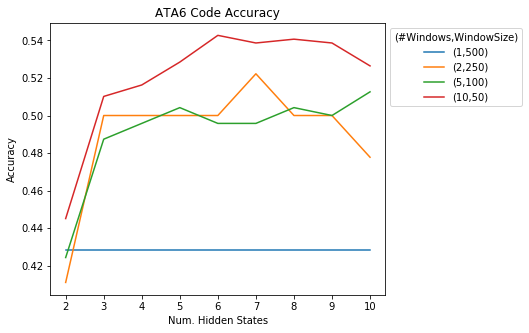

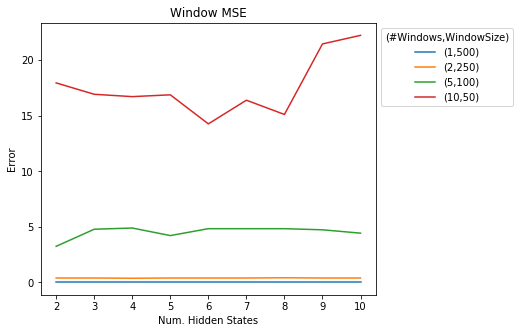

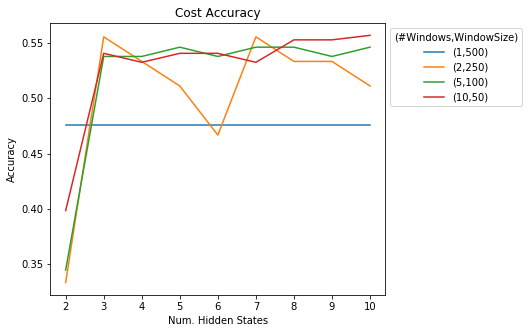

In [22]:
#num_windows = [10,5,2]
#num_windows = [20,10,5]#[1,10,5,5,5]#[1,10,20] #this is num_inits
#num_windows = [1,10,5,5,1,2,5,10,20]
#win_size = [50,10,20,50,500,250,100,50,25]
num_windows = [1,2,5,10]
win_size = [500,250,100,50]
num_states = range(2,11)

x_coord = num_states

z_labels = []
for i in range(len(num_windows)):
    temp = '(' + str(num_windows[i]) + ',' + str(win_size[i]) + ')'
    z_labels.append(temp)

#plt.figure()
#get_plots(code_errors_list, x_coord, z_labels, "ATA6 Code MSE", "Num. Hidden States", "Error")
#plt.savefig('ATA6_Code_MSE')

plt.figure()
get_plots(code_accuracies_list, x_coord, z_labels, "ATA6 Code Accuracy", "Num. Hidden States", "Accuracy")
#plt.savefig('ATA6_Code_Accuracy')

plt.figure()
get_plots(window_errors_list_mean, x_coord, z_labels, "Window Error - Mean", "Num. Hidden States", "Error")
#plt.savefig('Window_Error_Mean')

plt.figure()
get_plots(window_accuracies_list, x_coord, z_labels, "Window Error - Std. Dev.", "Num. Hidden States", "Error")
#plt.savefig('Window_Error_SD')

#plt.figure()
#get_plots(cost_errors_list, x_coord, z_labels, "Cost MSE", "Num. Hidden States", "Error")
#plt.savefig('Cost MSE')

plt.figure()
get_plots(cost_accuracies_list, x_coord, z_labels, "Cost Accuracy", "Num. Hidden States", "Accuracy")
#plt.savefig('Cost Accuracy')



In [164]:
np.savez('acc_5_20_gmm20inits.mat',code_accuracies_list, window_accuracies_list, cost_accuracies_list, code_errors_list, window_errors_list, cost_errors_list)

In [31]:
n_components = np.arange(1, 21)
models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(Xnum)
          for n in n_components]

bic_score = []
aic_score = []
for m in models:
    bic_score.append(m.bic(Xnum))

NameError: name 'Xnum' is not defined

In [25]:
num_states = 2
num_iter = 100
alpha = 0.5
num_inits = 1
num_windows = 5
window_size = 100
print('\ngetting maps for: ',num_windows, window_size)
train_combined, val_combined, test_combined = load_maps(num_windows, window_size)
print('training...')
models = start_train_gmm(selected_codes, train_combined, num_iter, num_states, num_inits)
print('validating and getting results...')
data = val_combined
#code_error, window_error, cost_error, code_accuracy, window_accuracy, cost_accuracy = get_results(alpha,selected_codes,data,veh_repair_map,num_windows, pc_vec2, cost_prob, veh_repair_cost_map)
code_error, window_error, cost_error, code_accuracy, window_accuracy, cost_accuracy, trueP_code, trueP_win, actualP_code, actualP_win, predP_code, predP_win = get_results(alpha,selected_codes,val_combined,veh_repair_map,num_windows, pc_vec2, cost_prob, veh_repair_cost_map)
print('ATA6 Code Error: ', code_error)
print('ATA6 Code Accuracy: ', code_accuracy)
#print('ATA6 Code Accuracy: ', np.mean(code_scores_acc))
print('Window Error: mean = %.2f, s.d. = %.2f' % (np.mean(window_error), np.std(window_error)))
print('Window Accuracy ', window_accuracy)
#print('Window Accuracy: ', np.mean(window_scores_acc))
print('Cost Error: ', cost_error)
print('Cost Accuracy: ', cost_accuracy)
#print('Cost Accuracy: ', np.mean(cost_scores_acc))


getting maps for:  5 100
training...
validating and getting results...
ATA6 Code Error:  0.584033613445
ATA6 Code Accuracy:  0.415966386555
Window Error: mean = -0.75, s.d. = 1.62
Window Accuracy  0.478942165101
Cost Error:  2.84033613445
Cost Accuracy:  0.344537815126


Percentile: Window Error
10: -3
20: -2
30: -2
40: -1
50: -1
60: 0
70: 0
80: 1
90: 1
100: 3


<Container object of 10 artists>

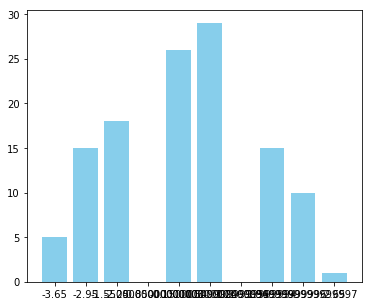

In [36]:
# plot histogram of window error
temp = np.sort(window_error)
print('Percentile: Window Error')
for i in range(10,110,10):
    sorted_index = round(i * len(temp)/100)    
    print('%d: %d' % (i,max(temp[0:sorted_index])))

(heights, bin_edges) = np.histogram(window_error)
bars = []
for i in range(len(heights)):
    bars.append(float(bin_edges[i] + bin_edges[i+1])/2.0)
numbars = len(bars)
plt.xticks(range(numbars), bars)
plt.bar(range(numbars), heights, align='center',color='skyblue')

In [87]:
acc_code, precision_code, recall_code, f1_code = confusion_metrics(selected_codes, trueP_code, actualP_code, predP_code)
acc_win, precision_win, recall_win, f1_win = confusion_metrics(range(num_windows), trueP_win, actualP_win, predP_win)
print('ATA6 Code Accuracy = %.2f' % acc_code)
print('Precision, Recall, F1:')
for i in selected_codes:
    print('%d: %.2f, %.2f, %.2f' % (i,precision_code[i], recall_code[i], f1_code[i]))

print('\nWindow Accuracy = %.2f' % acc_win)
print('Precision, Recall, F1:')
for i in range(num_windows):
    print('%d: %.2f, %.2f, %.2f' % (i,precision_win[i], recall_win[i], f1_win[i]))


ATA6 Code Accuracy = 0.42
Precision, Recall, F1:
0: nan, 0.00, nan
43004: nan, 0.00, nan
44004: 0.21, 0.40, 0.28
45002: nan, 0.00, nan
45007: nan, 0.00, nan
45008: nan, 0.00, nan
45021: 0.56, 0.67, 0.61

Window Accuracy = 0.24
Precision, Recall, F1:
0: 0.32, 0.47, 0.38
1: 0.19, 0.27, 0.22
2: 0.20, 0.25, 0.22
3: 0.00, 0.00, nan
4: 0.50, 0.06, 0.10


In [156]:
data = test_combined
#code_error, window_error, cost_error, code_accuracy, window_accuracy, cost_accuracy = get_results(alpha,selected_codes,data,veh_repair_map,num_windows, pc_vec2, cost_prob, veh_repair_cost_map)
code_error, window_error, cost_error, code_scores_acc, window_scores_acc, cost_scores_acc = get_results(alpha,selected_codes,data,veh_repair_map,num_windows, pc_vec2, cost_prob, veh_repair_cost_map)
print('ATA6 Code Error: ', code_error)
#print('ATA6 Code Accuracy: ', code_accuracy)
print('ATA6 Code Accuracy: ', np.mean(code_scores_acc))
print('Window Error: ', window_error)
#print('Window Accuracy: ', window_accuracy)
print('Window Accuracy: ', np.mean(window_scores_acc))
print('Cost Error: ', cost_error)
#print('Cost Accuracy: ', cost_accuracy)
print('Cost Accuracy: ', np.mean(cost_scores_acc))

ATA6 Code Error:  0.192307692308
ATA6 Code Accuracy:  0.807692307692
Window Error:  0.0
Window Accuracy:  1.0
Cost Error:  1.46153846154
Cost Accuracy:  0.769230769231


In [157]:
#data = val_combined
length = []
data_ATA6 = []
for vehicleID in data.keys():
    for ATA6code in data[vehicleID].keys():
        if ATA6code not in selected_codes:
            continue
        for time_window in data[vehicleID][ATA6code].keys():
            # append #sequences for (vehicleID,ATA6code,time_window)
            num_sequence = len(data[vehicleID][ATA6code][time_window])
            num_snapshots = np.zeros(num_sequence)            
            i = 0
            for sequence in data[vehicleID][ATA6code][time_window]:
                data_ATA6.append(ATA6code)
                num_snapshots[i] = (len(sequence))
                print('%d, %d, %d: Sequence %d, #Snapshots = %d' % (vehicleID,ATA6code,time_window,i,len(sequence)))
                #print('Sequence %d: %d snapshots' % (i,len(sequence)))
                i = i+1
            length.append(num_sequence)
            


132, 0, 0: Sequence 0, #Snapshots = 500
504, 45008, 0: Sequence 0, #Snapshots = 500
86, 45021, 0: Sequence 0, #Snapshots = 500
111, 0, 0: Sequence 0, #Snapshots = 500
92, 0, 0: Sequence 0, #Snapshots = 500
93, 0, 0: Sequence 0, #Snapshots = 500
113, 0, 0: Sequence 0, #Snapshots = 500
105, 0, 0: Sequence 0, #Snapshots = 500
106, 0, 0: Sequence 0, #Snapshots = 500
135, 0, 0: Sequence 0, #Snapshots = 500
120, 0, 0: Sequence 0, #Snapshots = 500
124, 0, 0: Sequence 0, #Snapshots = 500
125, 0, 0: Sequence 0, #Snapshots = 500


In [109]:
def get_learning_curve_models(selected_codes, train_map_revived, num_iter, num_states):
    models = {}
    codes = []
    code_window_map = {}
    for vehicleID in train_map_revived.keys():
        for ATA6code in train_map_revived[vehicleID].keys():
            if ATA6code not in selected_codes:
                continue
            if ATA6code not in code_window_map:
                code_window_map[ATA6code] = {}
            for time_window in train_map_revived[vehicleID][ATA6code].keys():
                if time_window not in code_window_map[ATA6code]:
                    code_window_map[ATA6code][time_window] = []
                for sequence_of_snapshots in train_map_revived[vehicleID][ATA6code][time_window]:
                    code_window_map[ATA6code][time_window].append(sequence_of_snapshots)

    for ATA6code in code_window_map.keys():
        for time_window in code_window_map[ATA6code].keys():
            listofsequences = code_window_map[ATA6code][time_window]
            if (ATA6code == 0):
                i = 0
                lengths = []
                X = pandas.concat(listofsequences.as_matrix())
                for sequence in listofsequences:
                    lengths.append(sequence.shape[0])
                    gmm = mixture.GaussianMixture(n_components=num_states, covariance_type='full', max_iter=num_iter, n_init=1)
                    models[(ATA6code, time_window, i)] = gmm.fit(X.astype(float))
            else:                      
                for i in range(len(listofsequences)):
                    lengths = []
                    X = pandas.concat(listofsequences[0:(i+1)]).as_matrix()
                    for sequence in listofsequences[0:(i+1)]:
                        lengths.append(sequence.shape[0]) 
                    #models[(ATA6code, time_window)] = hmm.GaussianHMM(n_components=num_states, n_iter=num_iter).fit(X.astype(float),lengths)
                    gmm = mixture.GaussianMixture(n_components=num_states, covariance_type='full', max_iter=num_iter, n_init=1)
                    models[(ATA6code, time_window, i)] = gmm.fit(X.astype(float))
    return models

In [97]:
ATA6code = 45021
time_window = 2
listofsequences = code_window_map[ATA6code][time_window]
for i in range(maxSequences[1]):
    if (i >= len(listofsequences)):
        break
        
    X = pandas.concat(listofsequences[0:(i+1)]).as_matrix()
    for sequence in listofsequences[0:(i+1)]:
        lengths.append(sequence.shape[0]) 
    #models[(ATA6code, time_window)] = hmm.GaussianHMM(n_components=num_states, n_iter=num_iter).fit(X.astype(float),lengths)
    gmm = mixture.GaussianMixture(n_components=num_states, covariance_type='full', max_iter=num_iter, n_init=1)
    models[(ATA6code, time_window, i)] = gmm.fit(X.astype(float))   
    
        


NameError: name 'numSequences' is not defined